# Prototype vorticity function w/ map factors

The goal of this notebook is to extract the essentials from the [previous notebook](MapProjectionExploration.ipynb) into a standalone function that computes vorticity.

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import pint
from pyproj import Proj
import xarray as xr

In [2]:
def read_nam_gdlist(name):
    file = open(name, 'rb')

    for _ in range(6):
        file.readline()

    grid_row = file.readline()
    nlon = int(grid_row[-11:-5].strip())
    nlat = int(grid_row[-4:].strip())
    #print(nlon,nlat)

    gempak_array = np.empty((nlat, nlon))

    for _ in range(2):
        file.readline()

    scale_row = file.readline()
    scale_factor = int(scale_row[19:].strip())
    #print(scale_factor)

    for _ in range(79):
        file.readline()

    col = 0
    row = 0
    
    for line in file.readlines():
        if (line[:8].strip() != b'') & (col >= nlon):
            col = 0
            row+=1
        for count in [0,1,2,3,4,5,6,7]:
            if (line[8+count*9:17+count*9]) == '\n':
                gempak_array[row, col] = np.nan
            else:
                gempak_array[row, col] = line[8+count*9:17+count*9]
            col+=1
            if col >= nlon: break

    file.close()
    
    return (gempak_array, -scale_factor)

def error_stats(metpy_data, gempak_data):
    ignore = (gempak_data != -9999.0) * ~np.isnan(metpy_data)
    
    if isinstance(metpy_data.data, pint.Quantity):
        print(f'Is Xarray with Quantity? True')
        mdata = metpy_data.values[ignore]
    elif isinstance(metpy_data, pint.Quantity):
        print(f'Is Xarray with Quantity? False')
        print(f'Is Metpy Unit Array? True')
        mdata = metpy_data.m[ignore]
    else:
        print(f'Is Xarray with Quantity? False')
        print(f'Is Metpy Unit Array? False')
        print(f'I got back just a numpy array')
        try:
            mdata = metpy_data.values[ignore]
        except:
            mdata = metpy_data[ignore]
    gempak_data = gempak_data[ignore]
    
    print()
    print('Mean Comparison')
    print(f'  Mean Values (MetPy): {mdata.mean()}')
    print(f'  Mean Values (GEMPAK): {gempak_data.mean()}')
    print()
    print('Max Comparison')
    print(f'  Max Values (MetPy): {mdata.max()}')
    print(f'  Max Values (GEMPAK): {gempak_data.max()}')
    print()
    print('Min Comparison')
    print(f'  Min Values (MetPy): {mdata.min()}')
    print(f'  Min Values (GEMPAK): {gempak_data.min()}')

    print()
    print('Difference Array')
    diff = mdata - gempak_data
    print(diff)
    print()
    print('Various Statistical Analyses')
    print(f'  Average Absolute Difference: {np.nanmean(np.abs(diff))}')
    print(f'  RMS Error: {np.sqrt(np.nansum(diff**2))/len(diff.ravel())}')
    print(f'  Standard Deviation of Difference: {np.nanstd(diff)}')
    print(f'  Max Diff: {np.max(diff)}')
    print(f'  Min Diff: {np.min(diff)}')
    print(f'  Correlation: {np.corrcoef(mdata.ravel(), gempak_data.ravel())[0][1]}')
    print(f'  Relative Magnitude Difference: {np.nanmean(np.abs(diff))/np.nanmax(mdata)}')
    print()
    
def extract_gemdata(out_var, scale):
    return out_var[::-1, :] * 10**scale

In [3]:
def vorticity(u, v, lat, lon, x, y, crs):
    """Calculate vorticity w/ map factors
    
    u and v are grid-relative left-right/up-down wind components
    lat and lon are the latitudes and longitudes (degrees) at each point on the grid
    x and y are the map coordinates at each point on the grid
    crs is the Cartopy coordinate reference system pertaining to the grid
    """   
    # Determine map factors
    p4 = Proj(projparams=crs.proj4_params)
    factors = p4.get_factors(lon, lat)
    m_x = factors.parallel_scale
    m_y = factors.meridional_scale
    
    # Determine nominal scale
    dx = x[1].values - x[0].values
    dy = y[1].values - y[0].values
    
    # Calculate vorticity using map factors
    dudy = mpcalc.first_derivative(u, delta=dy, axis=-2)
    dvdx = mpcalc.first_derivative(v, delta=dx, axis=-1)
    
    zeta = (m_x * dvdx - m_y * dudy
        - v * (m_x/m_y) * mpcalc.first_derivative(m_y, delta=dx, axis=-1)
        + u * (m_y/m_x) * mpcalc.first_derivative(m_x, delta=dy, axis=-2))
    
    return zeta

In [4]:
u = extract_gemdata(*read_nam_gdlist('urel218.txt'))
v = extract_gemdata(*read_nam_gdlist('vrel218.txt'))

# I didn't think this preprocessing was necessary, but my nominal scale is a bit
# off if I try to calculate it manually inside the vorticity function. The map
# coordinates I get in my manual calculation are somewhat different from the x
# and y values that metpy determines.
nam_data = xr.open_dataset('namanl_218_20180308_0000_000.nc').metpy.parse_cf()
nam_data = nam_data.metpy.assign_latitude_longitude()

lat = nam_data.latitude
lon = nam_data.longitude
x = nam_data.x
y = nam_data.y
# Redundant, but unsure of how to get proj4_params out of nam_data
grid218 = ccrs.LambertConformal(globe=ccrs.Globe(ellipse=None,
                                                 semimajor_axis=6371200), 
                                 standard_parallels=(25,25),
                                 central_longitude=-95, central_latitude=25)

zeta = vorticity(u, v, lat, lon, x, y, grid218)

In [5]:
# Obtain GEMPAK values for comparison
vor_gem = extract_gemdata(*read_nam_gdlist('vor218.txt'))

In [6]:
error_stats(zeta[3:-3,3:-3]*1e5, vor_gem[3:-3,3:-3]*1e5)

Is Xarray with Quantity? False
Is Metpy Unit Array? True

Mean Comparison
  Mean Values (MetPy): -0.07599541804749045
  Mean Values (GEMPAK): -0.07599521389373916

Max Comparison
  Max Values (MetPy): 170.6665562580801
  Max Values (GEMPAK): 170.6667

Min Comparison
  Min Values (MetPy): -91.94772125712056
  Min Values (GEMPAK): -91.9478

Difference Array
[-4.64724448e-05  7.12490102e-06 -4.44076910e-05 ... -2.11806358e-05
  2.56349327e-05 -2.84863552e-06]

Various Statistical Analyses
  Average Absolute Difference: 2.5518095901142474e-05
  RMS Error: 5.879902834808539e-08
  Standard Deviation of Difference: 2.978296709441113e-05
  Max Diff: 0.00017007088193565778
  Min Diff: -0.0001561884610623565
  Correlation: 0.999999999989812
  Relative Magnitude Difference: 1.4952018989915216e-07



/home/decker/local/miniconda3/envs/metpy21/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


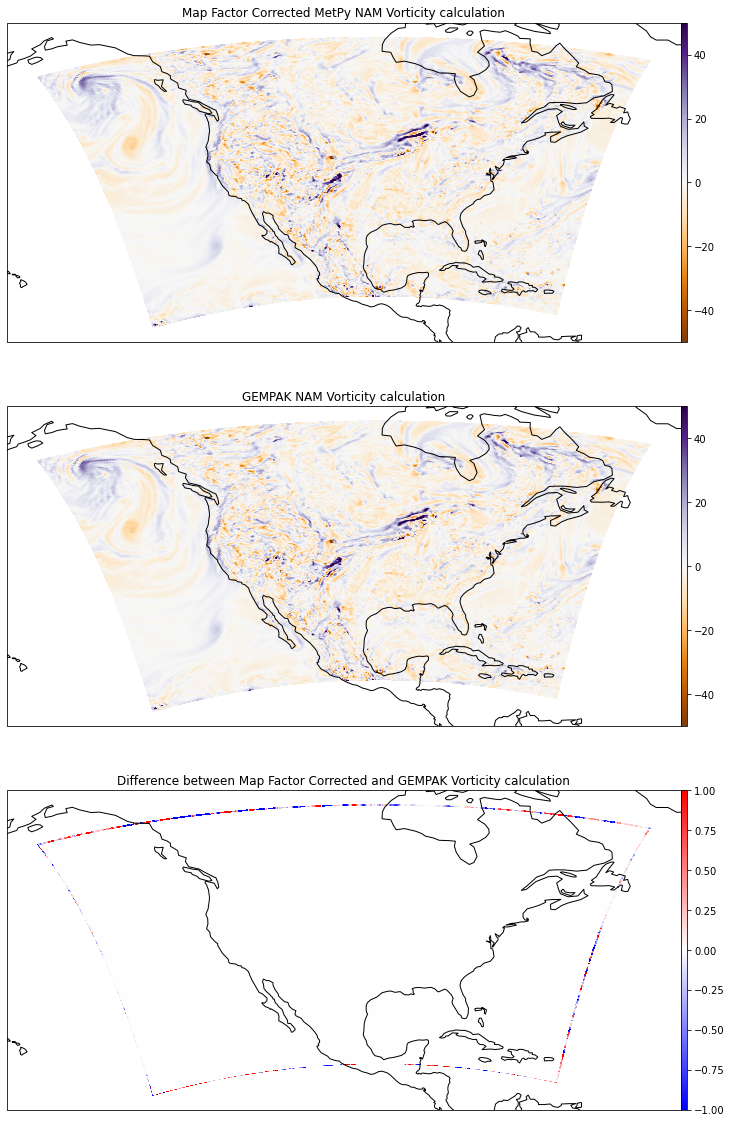

In [7]:
fig = plt.figure(1, figsize=(20, 20))
ax = plt.subplot(311, projection=ccrs.PlateCarree())
cf = ax.pcolormesh(lon, lat, zeta*1e5,
                   cmap=plt.cm.PuOr, shading='auto', vmin=-50, vmax=50)
plt.colorbar(cf, orientation='vertical', pad=0, aspect=50)
ax.coastlines()
plt.title('Map Factor Corrected MetPy NAM Vorticity calculation')

ax1 = plt.subplot(312, projection=ccrs.PlateCarree())
cf = ax1.pcolormesh(lon, lat, vor_gem*1e5,
                    cmap=plt.cm.PuOr, shading='auto', vmin=-50, vmax=50)
plt.colorbar(cf, orientation='vertical', pad=0, aspect=50)
ax1.coastlines()
plt.title('GEMPAK NAM Vorticity calculation')

ax2 = plt.subplot(313, projection=ccrs.PlateCarree())
cf = ax2.pcolormesh(lon, lat, zeta*1e5-vor_gem*1e5,
                    cmap=plt.cm.bwr, vmin=-1, vmax=1, shading='auto')
plt.colorbar(cf, orientation='vertical', pad=0, aspect=50)
ax2.coastlines()
plt.title('Difference between Map Factor Corrected and GEMPAK Vorticity calculation')
plt.show()

## Now with Kevin's data

In [8]:
nam_data = xr.open_dataset('namanl_218_20180308_0000_000.nc').metpy.parse_cf()
nam_data = nam_data.metpy.assign_latitude_longitude()

u = nam_data['u-component_of_wind_isobaric'].metpy.sel(time=datetime(2018, 3, 8, 0), vertical=500*units.hPa).metpy.quantify()
v = nam_data['v-component_of_wind_isobaric'].metpy.sel(time=datetime(2018, 3, 8, 0), vertical=500*units.hPa).metpy.quantify()

lat = nam_data.latitude
lon = nam_data.longitude
x = nam_data.x
y = nam_data.y

grid218 = ccrs.LambertConformal(globe=ccrs.Globe(ellipse=None,
                                                 semimajor_axis=6371200), 
                                 standard_parallels=(25,25),
                                 central_longitude=-95, central_latitude=25)

zeta = vorticity(u, v, lat, lon, x, y, grid218)

In [9]:
# Obtain GEMPAK values for comparison
vor_gem = extract_gemdata(*read_nam_gdlist('nam_gempak_vorticity.out'))

In [10]:
error_stats(zeta[3:-3,3:-3]*1e5, vor_gem[3:-3,3:-3]*1e5)

Is Xarray with Quantity? True

Mean Comparison
  Mean Values (MetPy): 0.006461877096968294
  Mean Values (GEMPAK): 0.006462539715328003

Max Comparison
  Max Values (MetPy): 63.92226070664399
  Max Values (GEMPAK): 63.92227

Min Comparison
  Min Values (MetPy): -51.37795326330724
  Min Values (GEMPAK): -51.377970000000005

Difference Array
[ 7.47700688e-06 -4.79552881e-06 -1.76558806e-06 ... -2.54298595e-06
  1.33963733e-05 -1.46285529e-05]

Various Statistical Analyses
  Average Absolute Difference: 6.79091040252962e-06
  RMS Error: 1.8915288402246606e-08
  Standard Deviation of Difference: 9.558283607561744e-06
  Max Diff: 5.655894486444879e-05
  Min Diff: -8.420982244317088e-05
  Correlation: 0.9999999999990385
  Relative Magnitude Difference: 1.0623701864511469e-07



/home/decker/local/miniconda3/envs/metpy21/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


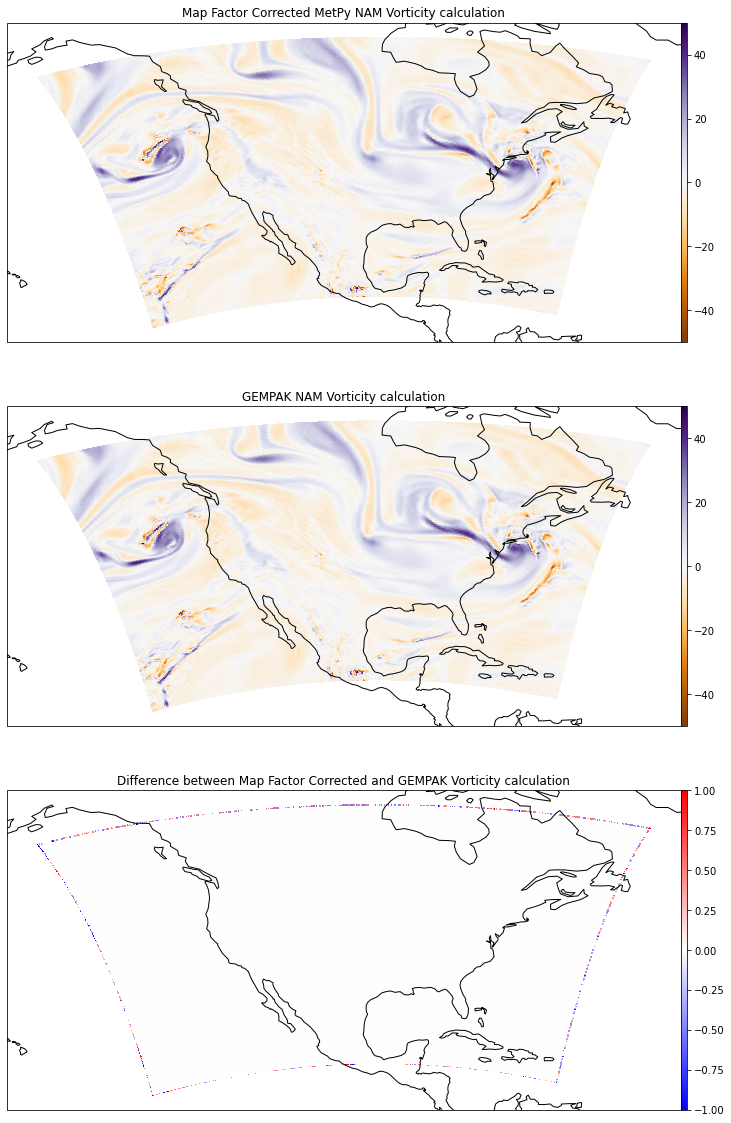

In [11]:
fig = plt.figure(1, figsize=(20, 20))
ax = plt.subplot(311, projection=ccrs.PlateCarree())
cf = ax.pcolormesh(lon, lat, zeta*1e5,
                   cmap=plt.cm.PuOr, shading='auto', vmin=-50, vmax=50)
plt.colorbar(cf, orientation='vertical', pad=0, aspect=50)
ax.coastlines()
plt.title('Map Factor Corrected MetPy NAM Vorticity calculation')

ax1 = plt.subplot(312, projection=ccrs.PlateCarree())
cf = ax1.pcolormesh(lon, lat, vor_gem*1e5,
                    cmap=plt.cm.PuOr, shading='auto', vmin=-50, vmax=50)
plt.colorbar(cf, orientation='vertical', pad=0, aspect=50)
ax1.coastlines()
plt.title('GEMPAK NAM Vorticity calculation')

ax2 = plt.subplot(313, projection=ccrs.PlateCarree())
cf = ax2.pcolormesh(lon, lat, zeta.values*1e5-vor_gem*1e5,
                    cmap=plt.cm.bwr, vmin=-1, vmax=1, shading='auto')
plt.colorbar(cf, orientation='vertical', pad=0, aspect=50)
ax2.coastlines()
plt.title('Difference between Map Factor Corrected and GEMPAK Vorticity calculation')
plt.show()